In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.models import Range1d

from math import atan2, pi, sqrt, pow

from scipy.stats import linregress

output_notebook()

Loading BokehJS ...

In [4]:
att_f = 'Vissim George CBD - Current Existing_Link Segment Results 02.att'

att_path = 'C:/Users/shafeeq.mollagee/OneDrive - Aurecon Group/GIPTN Traffic Modelling/04 - CBD Modelling/08 - Micro Model/03 - Final Base Model/Rev 08/Scenarios/S000001/S000001.results/%s' % (att_f)

att = pd.read_table(att_path, sep = ";", header=20, dtype = {'$LINKEVALSEGMENTEVALUATION:SIMRUN' : object})

save_path = 'D:/001_Projects/01 - GIPTN/07 - CBD Micro Model/CBD Vissim Model/%s.csv' % ("combinetest")

simrun = '339'

df = combine(process_link_volumes (att, simrun), simrun, save_path)

In [3]:

def process_link_volumes (df, simrun):
    # filter to selected simulation run and summarise link evaluation results to madfimum value
    y = str (simrun)
    df['$LINKEVALSEGMENTEVALUATION:SIMRUN'] = df['$LINKEVALSEGMENTEVALUATION:SIMRUN'].apply(str)
    df['LINKEVALSEGMENT'] = df['LINKEVALSEGMENT'].str.split('-').str[0]
    df = df.groupby(by = ['$LINKEVALSEGMENTEVALUATION:SIMRUN', 'TIMEINT', 'LINKEVALSEGMENT', 'LINKEVALSEGMENT\LINK\AM_PEAK_HOUR_COUNTS'])[
        'DENSITY(ALL)', 
        'DELAYREL(ALL)', 
        'SPEED(ALL)',
        'VOLUME(ALL)'].max().reset_index()
    df["LINKEVALSEGMENT"] = pd.to_numeric(df["LINKEVALSEGMENT"])
    df = df.loc[df['$LINKEVALSEGMENTEVALUATION:SIMRUN'] == y]
    return df

def GEH (x,y):
    # calculate GEH statistic
    if x + y == 0:
        g = 0 
    else: 
        g = sqrt(2*(pow(x-y,2))/(x+y))
    return g

def combine (df, simrun, path):
    # prepare the input dataframe for the Bokeh graph
    
    df = df.rename(index=str, columns={'$LINKEVALSEGMENTEVALUATION:SIMRUN': 'SIMRUN', 
                                        'VOLUME(ALL)': 'VISVOL', 
                                        'LINKEVALSEGMENT\LINK\AM_PEAK_HOUR_COUNTS': 'BALANCED_COUNT'})
    # apply GEH statistic calculation to count and modelled volumes
    df['GEH'] = df.apply(lambda x: GEH(x['VISVOL'], x['BALANCED_COUNT']), axis=1)
    # calculate glyph colour based on GEH band
    df['COLOUR'] = np.where(df['GEH']<5, '#a8c686', np.where(df['GEH']>10,'#e4572e','#f3a712'))
        
    df.to_csv(path)
    
    return df

#combine(count, att, 2, save_path)

def qreg(att):
    # plot a quick regression curve in seaborn
    sns.lmplot(x='BALANCED_COUNT', y='VISVOL', data = att)

def geh5():
    x = df[df["GEH"]>5].count()[0]
    y = len(df)
    z = (y-x)/y
        
    return z

def geh10():
    x = df[df["GEH"]>10].count()[0]
    y = len(df)
    z = (y-x)/y
        
    return z

def rsq():   
    return linregress(df['BALANCED_COUNT'], df['VISVOL'])

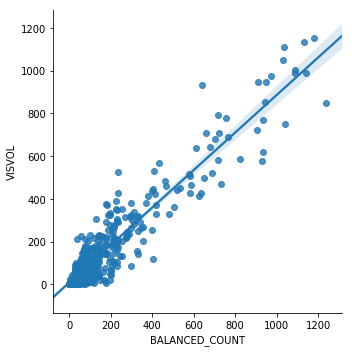

In [5]:
qreg(df)

In [6]:

regression = np.polyfit(df['BALANCED_COUNT'], df['VISVOL'], 1)
r_x, r_y = zip(*((i, i*regression[0] + regression[1]) for i in range(len(df))))

yDiff = r_y[len(df)-1] - r_y[0]
xDiff = r_x[len(df)-1] - r_x[0]

ang = atan2(yDiff, xDiff)

source = ColumnDataSource(df)

p = figure(width=650, height=650)
p.circle(x='BALANCED_COUNT', y='VISVOL', 
         source=source, 
         size=10, color='COLOUR', alpha=0.5)

p.title.text = 'Modelled vs Balanced Observed Counts by GEH'
p.xaxis.axis_label = 'Balanced Observed Volume'
p.yaxis.axis_label = 'Modelled Volume'

hover = HoverTool()
hover.tooltips=[
    ('Turn Link Number', '@LINKEVALSEGMENT'),
    ('Simulation Run', '@SIMRUN'),
    ('Time Interval', '@TIMEINT'),
    ('Modelled Volume', '@VISVOL'),
    ('Balanced Volume', '@BALANCED_COUNT'),
    ('GEH Statistic', '@GEH')
]

p.add_tools(hover)

p.line(r_x, r_y, color="#669bbc", line_width=1.25)
p.ray(x=[1, r_x[0]], 
      y=[1, r_y[0]], 
      length=0, 
      angle=[pi/4, ang], 
      color=["#29335c", "#669bbc"], 
      line_width=[2, 1.25])

p.y_range = Range1d(0, 1200)
p.x_range = Range1d(0, 1200)

show(p)

In [7]:
geh5()

0.6203703703703703

In [8]:
geh10()

0.9027777777777778

In [9]:
ang

0.7200124939841903

In [10]:
rsq()

LinregressResult(slope=0.8770900050748689, intercept=8.587256482653544, rvalue=0.9400118572137872, pvalue=5.938747789713571e-203, stderr=0.01535011038354909)